In [1]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.50
    Uninstalling yfinance-0.2.50:
      Successfully uninstalled yfinance-0.2.50
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib.dates import DateFormatter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Functions for calculating indicators (SMA, RSI, etc.) and generating trading signals

def calculate_sma(df, window):
    return df['Close'].rolling(window=window).mean()

def calculate_ema(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def calculate_macd(df):
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_rsi(df):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(df):
    middle_bb = df['Close'].rolling(window=20).mean()
    upper_bb = middle_bb + 2 * df['Close'].rolling(window=20).std()
    lower_bb = middle_bb - 2 * df['Close'].rolling(window=20).std()
    return middle_bb, upper_bb, lower_bb

def calculate_stochastic_oscillator(df):
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    slowk = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    slowd = slowk.rolling(window=3).mean()
    return slowk, slowd

def calculate_cmf(df, window=20):
    mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    cmf = mfv.rolling(window=window).sum() / df['Volume'].rolling(window=window).sum()
    return cmf

def calculate_cci(df, window=20):
    """Calculate Commodity Channel Index (CCI)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma = typical_price.rolling(window=window).mean()
    mean_deviation = (typical_price - sma).abs().rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci

# Function to generate trading signals
def generate_trading_signals(df):
    df['SMA_30'] = calculate_sma(df, 30)
    df['SMA_100'] = calculate_sma(df, 100)
    df['EMA_12'] = calculate_ema(df, 12)
    df['EMA_26'] = calculate_ema(df, 26)
    df['RSI'] = calculate_rsi(df)
    df['MiddleBB'], df['UpperBB'], df['LowerBB'] = calculate_bollinger_bands(df)
    df['SlowK'], df['SlowD'] = calculate_stochastic_oscillator(df)
    df['CMF'] = calculate_cmf(df)
    df['CCI'] = calculate_cci(df)
    macd, signal = calculate_macd(df)
    df['MACD'] = macd
    df['MACD_Signal_Line'] = signal
    return df


In [5]:
def prepare_ml_data(ticker, start_date, end_date, window_size=15, plot=True):
    """
    Prepares stock data for trend classification using PyTorch GPU acceleration.
    Adds binary trend labels (0 for downtrend, 1 for uptrend) and optional visualization.
    
    Parameters:
        ticker (str): Stock ticker symbol (e.g., 'AAPL').
        start_date (str): Start date for data download (e.g., '2020-01-01').
        end_date (str): End date for data download (e.g., '2023-01-01').
        window_size (int): Number of days to compute the slope (default: 15).
        plot (bool): Whether to generate visualization plots (default: True).
        
    Returns:
        df (pd.DataFrame): DataFrame with 'Future_Slope' and 'Trend' columns.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    df = yf.download(ticker, start=start_date, end=end_date)
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    if 'Adj Close' in df.columns:
        df = df.drop('Adj Close', axis=1)
    
    close_prices = torch.tensor(df['Close'].values, dtype=torch.float32).to(device)
    close_prices = close_prices.view(1, 1, -1)
    
    windows = torch.nn.functional.unfold(close_prices, 
                                         kernel_size=(1, window_size), 
                                         stride=1)
    
    windows = windows.squeeze(0).transpose(0, 1)
    
    x = torch.arange(window_size, dtype=torch.float32).to(device)
    sum_x = torch.sum(x)
    sum_x_sq = torch.sum(x ** 2)
    denominator = window_size * sum_x_sq - sum_x ** 2
    
    sum_y = torch.sum(windows, dim=1)
    sum_xy = torch.sum(windows * x, dim=1)
    numerator = window_size * sum_xy - sum_x * sum_y
    slopes = numerator / denominator
    
    slopes_cpu = slopes.cpu().numpy()
    
    future_slopes = np.full(len(df), np.nan)
    future_slopes[:len(slopes_cpu)] = slopes_cpu
    df = df.assign(Future_Slope=future_slopes)
    
    mean_slope = np.nanmean(df['Future_Slope'])
    df['Future_Slope'] = df['Future_Slope'].fillna(mean_slope)
    
    # Binary Classification: 1 for Uptrend, 0 for Downtrend
    df['Trend'] = (df['Future_Slope'] > 0).astype(int)
    
    return df

In [6]:
def visualize_trends(df, ticker, window_size):
    """
    Creates visualizations of the stock data and binary trend classifications.
    
    Parameters:
        df (pd.DataFrame): Processed DataFrame with trend information
        ticker (str): Stock ticker symbol
        window_size (int): Window size used for slope calculation
    """
    # Create a figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), gridspec_kw={'height_ratios': [3, 1, 1]})
    
    # Plot 1: Price and trend
    ax1.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.7)
    
    # Color regions based on trend
    up_mask = df['Trend'] == 1
    down_mask = df['Trend'] == 0
    
    # Plot colored backgrounds for trend periods
    for trend, mask, color in [('Uptrend', up_mask, 'lightgreen'), 
                               ('Downtrend', down_mask, 'lightcoral')]:
        # Find consecutive periods
        if mask.any():
            trend_periods = []
            period_start = None
            
            for i, val in enumerate(mask):
                if val and period_start is None:
                    period_start = i
                elif not val and period_start is not None:
                    trend_periods.append((period_start, i-1))
                    period_start = None
            
            # Handle the case where the last period extends to the end
            if period_start is not None:
                trend_periods.append((period_start, len(mask)-1))
            
            # Shade each period
            for start, end in trend_periods:
                if start < len(df.index) and end < len(df.index):
                    ax1.axvspan(df.index[start], df.index[end], alpha=0.2, color=color)
    
    # Customize plot 1
    ax1.set_title(f'{ticker} Stock Price with Binary Trend Classification (Window: {window_size})')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Future Slope values
    ax2.plot(df.index, df['Future_Slope'], color='darkblue')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='Neutral Slope')
    ax2.set_ylabel('Slope')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Trend distribution
    trend_counts = df['Trend'].value_counts()
    colors = {1: 'purple', 0: 'lightcoral'}
    sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=colors, ax=ax3)
    ax3.set_title('Distribution of Trend Classifications')
    ax3.set_ylabel('Count')
    
    # Add percentages on top of bars
    total = len(df)
    for i, count in enumerate(trend_counts):
        percentage = 100 * count / total
        ax3.text(i, count + 5, f'{percentage:.1f}%', ha='center')
    
    # Format date on x-axis
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_formatter(date_form)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Confusion matrix-style visualization of trend transitions
    plt.figure(figsize=(6, 4))
    
    # Create transition matrix
    transitions = pd.crosstab(df['Trend'].shift(), df['Trend'], 
                             rownames=['From'], colnames=['To'],
                             normalize='index')
    
    # Rename the labels
    labels = ['Down', 'Up']
    
    # Plot heatmap
    sns.heatmap(transitions, annot=True, cmap='Purples', fmt='.1%', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Transition Probability'})
    
    plt.title('Trend Transition Probabilities')
    plt.tight_layout()
    plt.show()

In [7]:
# Define parameters
ticker = "BABA"
start_date = "2021-01-01"
end_date = "2026-01-01"
window_size = 15

df = yf.download(ticker, start=start_date, end=end_date)
    
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
    
if 'Adj Close' in df.columns:
    df = df.drop('Adj Close', axis=1)
    

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [8]:
df

Price,Close,High,Low,Open,Volume
Date,,,,,
2021-01-04,220.045380,222.488717,217.331619,218.741616,24897900
2021-01-05,232.165482,232.513151,220.306114,221.204266,35823800
2021-01-06,219.813583,230.137417,218.123527,226.902160,37146100
2021-01-07,219.127899,222.073429,212.551167,221.455352,49361800
2021-01-08,228.099701,230.427154,218.918344,220.074349,34884900
...,...,...,...,...,...
2025-03-18,142.740005,146.869995,142.500000,146.380005,20950100
2025-03-19,143.199997,145.199997,141.869995,145.070007,16333800
2025-03-20,136.910004,138.990005,136.369995,137.175003,23646800


## **Preprocess Data**

In [9]:
# Define parameters
ticker = "BABA"
start_date = "2020-01-01"
end_date = "2026-01-01"
window_size = 15

# Example usage
df = prepare_ml_data('BABA', start_date, end_date, window_size=window_size, plot=True)

[*********************100%***********************]  1 of 1 completed


Using device: cuda


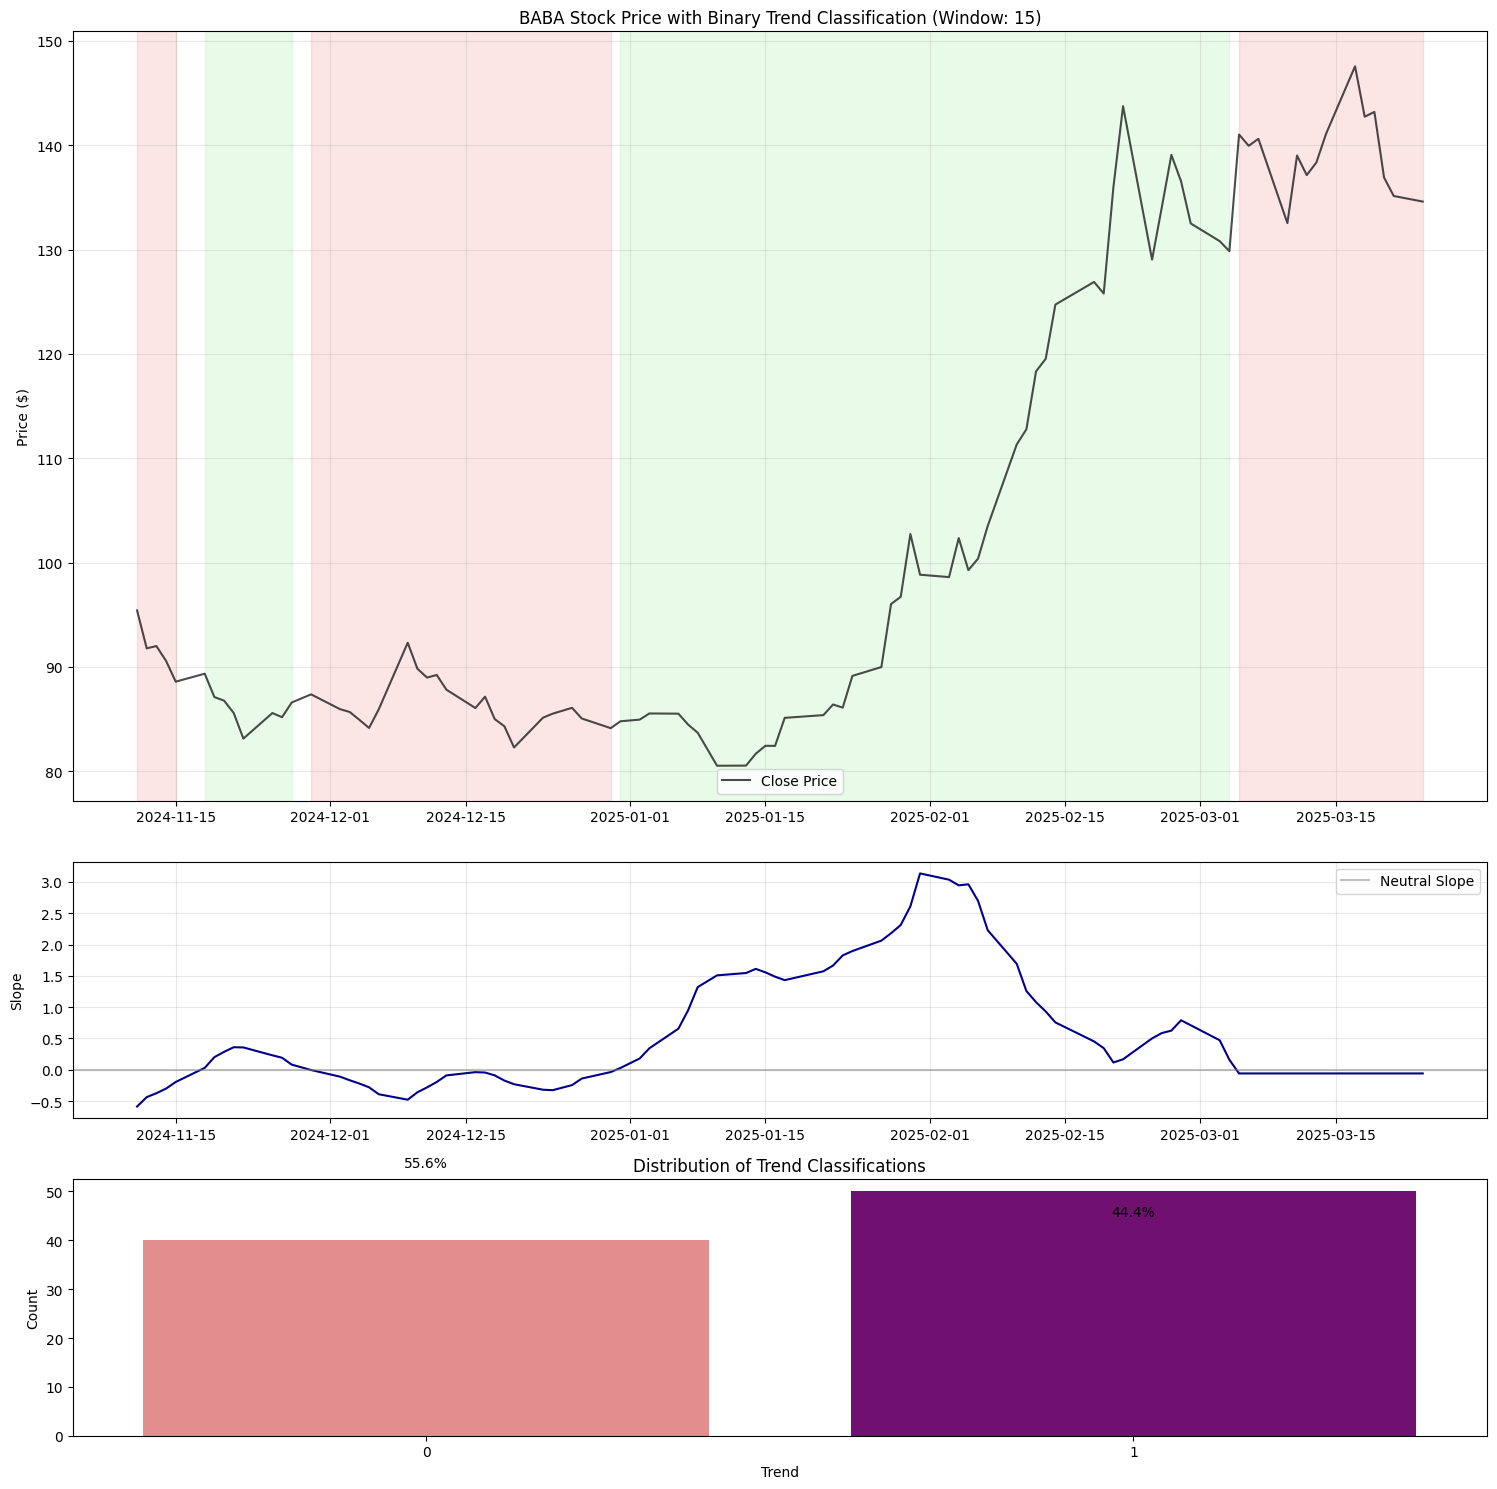

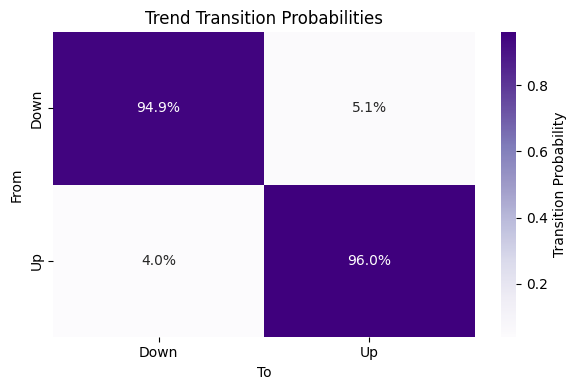

In [10]:
visualize_trends(df.tail(90), ticker, window_size)

In [11]:
# Generate indicators
data = generate_trading_signals(df)

In [12]:
data

Price,Close,High,Low,Open,Volume,Future_Slope,Trend,SMA_30,SMA_100,EMA_12,...,RSI,MiddleBB,UpperBB,LowerBB,SlowK,SlowD,CMF,CCI,MACD,MACD_Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,212.242142,212.444940,209.122769,209.180727,15873500,0.421064,1,NaN,NaN,212.242142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2020-01-03,209.567017,210.728813,208.610922,208.939287,8604500,0.154107,1,NaN,NaN,211.830584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.213400,-0.042680
2020-01-06,209.219345,209.721537,206.756688,207.529289,11885500,-0.368452,0,NaN,NaN,211.428855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.405897,-0.115323
2020-01-07,210.175446,211.440571,209.267641,210.185098,9388000,-0.746213,0,NaN,NaN,211.236023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.475817,-0.187422
2020-01-08,210.532761,213.091983,208.910313,209.180721,11959100,-1.031347,0,NaN,NaN,211.127829,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.496672,-0.249272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-18,142.740005,146.869995,142.500000,146.380005,20950100,-0.058156,0,128.551334,101.23710,138.704555,...,53.397700,136.87100,147.956589,125.785412,74.518636,82.849677,-0.128728,33.702802,8.078242,8.727460
2025-03-19,143.199997,145.199997,141.869995,145.070007,16333800,-0.058156,0,129.913000,101.66450,139.396162,...,56.420151,137.74150,147.854973,127.628028,76.578607,82.415329,-0.118004,28.266214,7.838465,8.549661
2025-03-20,136.910004,138.990005,136.369995,137.175003,23646800,-0.058156,0,131.167334,102.05360,139.013676,...,54.071067,137.78850,147.876013,127.700988,48.410246,66.502496,-0.101065,-2.739589,7.059512,8.251631


In [13]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(data.shape)


# Check for missing values
missing_columns = data.columns[data.isnull().any()]
if missing_columns.size > 0:
    missing_values = data[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")

Data Shape:
(1313, 21)

Missing Data:
          Total   Percent
Price                    
SMA_100      99  7.539985
CCI          38  2.894136
SMA_30       29  2.208682
MiddleBB     19  1.447068
LowerBB      19  1.447068
UpperBB      19  1.447068
CMF          19  1.447068
SlowD        15  1.142422
RSI          13  0.990099
SlowK        13  0.990099


In [14]:
# View the last few rows with the new categorical column
data[['Close', 'Future_Slope', 'Trend']].sample(5)

Price,Close,Future_Slope,Trend
Date,,,
2024-03-06,72.142097,-0.156492,0
2025-02-03,98.610001,3.036607,1
2020-04-24,197.359985,-0.181429,0
2024-12-13,87.820000,-0.089647,0
2025-03-21,135.139999,-0.058156,0


In [15]:
data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Future_Slope', 'Trend',
       'SMA_30', 'SMA_100', 'EMA_12', 'EMA_26', 'RSI', 'MiddleBB', 'UpperBB',
       'LowerBB', 'SlowK', 'SlowD', 'CMF', 'CCI', 'MACD', 'MACD_Signal_Line'],
      dtype='object', name='Price')

In [16]:
data = data.dropna()

## **XGBoost**

In [35]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.samplers import TPESampler


# =====================================================================
# 2. DATA PREPARATION
# =====================================================================
features = [
    'EMA_12', 'EMA_26', 'RSI', 'Close',
    'MiddleBB', 'UpperBB', 'LowerBB', 'SlowK', 'SlowD',
    'CMF', 'CCI', 'MACD', 'MACD_Signal_Line','Volume'
]

X = data[features]
y = data['Trend']

# Time-based split with buffer
split_idx = int(len(X) * 0.75)  # More training data
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# =====================================================================
# 3. FOCUSED OPTUNA OPTIMIZATION
# =====================================================================
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'device': 'cuda',
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'early_stopping_rounds': 20,
        'random_state': 42
    }
    
    tscv = TimeSeriesSplit(n_splits=3)  # Faster validation
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = XGBClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        # Track accuracy instead of logloss
        scores.append(accuracy_score(y_val, model.predict(X_val)))
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=30, timeout=1800)  # Reduced trials

# =====================================================================
# 4. FINAL MODEL WITH CLASS BALANCING
# =====================================================================
best_params = study.best_params
pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])  # Handle imbalance

final_model = XGBClassifier(
    **best_params,
    scale_pos_weight=pos_weight,
    device='cuda'
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50  # Less verbose
)

# =====================================================================
# 5. ENHANCED EVALUATION
# =====================================================================
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]  # Probabilities

print(f"\n🔥 Best Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
importance = pd.Series(final_model.feature_importances_, index=X.columns)
print("\n🎯 Top 15 Features:")
print(importance.sort_values(ascending=False).head(15))

[I 2025-03-24 19:34:40,769] A new study created in memory with name: no-name-2a0a9641-9e29-456e-9347-28061eacbebd
[I 2025-03-24 19:34:41,003] Trial 0 finished with value: 0.487518355359765 and parameters: {'max_depth': 4, 'learning_rate': 0.021775313831160072, 'n_estimators': 404, 'min_child_weight': 7, 'gamma': 0.2769672939361845, 'subsample': 0.9795105007069158, 'colsample_bytree': 0.9378589825264126, 'reg_alpha': 2.9017009600490065, 'reg_lambda': 4.507727746950901}. Best is trial 0 with value: 0.487518355359765.
[I 2025-03-24 19:34:41,249] Trial 1 finished with value: 0.49632892804698975 and parameters: {'max_depth': 5, 'learning_rate': 0.0242408555861146, 'n_estimators': 225, 'min_child_weight': 4, 'gamma': 0.15489716946129317, 'subsample': 0.7111635401740962, 'colsample_bytree': 0.957981094046273, 'reg_alpha': 1.0487875030700282, 'reg_lambda': 4.490113624749404}. Best is trial 1 with value: 0.49632892804698975.
[I 2025-03-24 19:34:41,457] Trial 2 finished with value: 0.49632892804

[0]	validation_0-logloss:0.69595
[50]	validation_0-logloss:0.74530
[100]	validation_0-logloss:0.75113
[150]	validation_0-logloss:0.75800
[200]	validation_0-logloss:0.75800
[250]	validation_0-logloss:0.75800
[300]	validation_0-logloss:0.75800
[350]	validation_0-logloss:0.75800
[400]	validation_0-logloss:0.75800
[450]	validation_0-logloss:0.75800
[482]	validation_0-logloss:0.75800

🔥 Best Model Accuracy: 0.5461

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.66      0.57       139
           1       0.61      0.45      0.52       165

    accuracy                           0.55       304
   macro avg       0.56      0.56      0.54       304
weighted avg       0.56      0.55      0.54       304


🎯 Top 15 Features:
Price
Close               0.111509
EMA_12              0.099263
EMA_26              0.091191
Volume              0.082718
MACD                0.077447
CMF                 0.076281
MACD_Signal_Line    0.067816
Upper

In [41]:
best_model = final_model

In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[92 47]
 [91 74]]


In [48]:
# Feature importance analysis
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
print("\nFeature Importance:")
for idx in sorted_idx:
    print(f"{features[idx]}: {feature_importance[idx]:.4f}")


Feature Importance:
Close: 0.1115
EMA_12: 0.0993
EMA_26: 0.0912
Volume: 0.0827
MACD: 0.0774
CMF: 0.0763
MACD_Signal_Line: 0.0678
UpperBB: 0.0673
LowerBB: 0.0657
SlowD: 0.0654
SlowK: 0.0597
MiddleBB: 0.0573
RSI: 0.0476
CCI: 0.0309


In [43]:
# Save the model
best_model.save_model("best_xgboost_model.json")
print("\nModel saved as 'best_xgboost_model.json'")

# Save the model using joblib
joblib.dump(best_model, 'xgboost_stock_model_gpu.pkl')
print("Model saved as 'xgboost_stock_model_gpu.pkl'")


Model saved as 'best_xgboost_model.json'
Model saved as 'xgboost_stock_model_gpu.pkl'


In [44]:
# Function to generate features for future dates
def generate_future_features(last_row):
    """
    Generate features for future dates based on the last available data.
    
    Parameters:
        last_row (pd.Series): The last row of the DataFrame containing the latest data.
        
    Returns:
        future_row (pd.Series): A row with features for future dates.
    """
    future_row = last_row.copy()
    
    # Update features that depend on rolling windows (e.g., SMA, RSI)
    future_row['EMA_12'] = future_row['Close']  # Assume EMA remains the same
    future_row['EMA_26'] = future_row['Close']  # Assume EMA remains the same
    future_row['RSI'] = future_row['RSI']  # Assume RSI remains the same
    future_row['MiddleBB'] = future_row['MiddleBB']  # Assume Bollinger Bands remain the same
    future_row['UpperBB'] = future_row['UpperBB']
    future_row['LowerBB'] = future_row['LowerBB']
    future_row['SlowK'] = future_row['SlowK']  # Assume Stochastic Oscillator remains the same
    future_row['SlowD'] = future_row['SlowD']
    future_row['CMF'] = future_row['CMF']  # Assume CMF remains the same
    future_row['CCI'] = future_row['CCI']  # Assume CCI remains the same
    future_row['MACD'] = future_row['MACD']  # Assume MACD remains the same
    future_row['MACD_Signal_Line'] = future_row['MACD_Signal_Line']
    
    return future_row

In [45]:
def predict_future(ticker, start_date, end_date=None):
    # Use current date if end_date is not provided
    if end_date is None:
        end_date = datetime.datetime.now().strftime('%Y-%m-%d')
    
    # Download new data
    try:
        new_data = yf.download(ticker, start=start_date, end=end_date)
    except Exception as e:
        print(f"Failed to download data: {e}")
        return pd.DataFrame()
    
    if new_data.empty:
        print("No data downloaded.")
        return pd.DataFrame()
    
    # Drop 'Adj Close' if present
    if 'Adj Close' in new_data.columns:
        new_data.drop('Adj Close', axis=1, inplace=True)
    
    # Generate indicators
    new_data = generate_trading_signals(new_data)
    
    # Ensure all required features are present
    missing_features = [f for f in features if f not in new_data.columns]
    if missing_features:
        print(f"Missing features: {missing_features}")
        return pd.DataFrame()
    
    # Prepare features and retain 'Close'
    X_new = new_data[features].copy()
    
    # Check if columns are a MultiIndex
    if isinstance(X_new.columns, pd.MultiIndex):
        # Convert MultiIndex to regular Index
        X_new.columns = X_new.columns.get_level_values(0)
    
    # Trim trailing spaces from column names (if any)
    X_new.columns = X_new.columns.str.strip()
    
    # Ensure the feature names match the training data exactly
    X_new = X_new[features]  # Reorder columns to match training data
    
    X_new.dropna(inplace=True)
    
    if X_new.empty:
        print("No valid data after preprocessing.")
        return pd.DataFrame()
    
    # Make predictions
    predictions = best_model.predict(X_new)
    
    # Align predictions with original data (keep 'Close')
    new_data = new_data.loc[X_new.index].copy()
    new_data['Prediction'] = predictions  # Add predictions
    
    return new_data

In [46]:
# Example usage
future_data = predict_future(ticker, start_date, end_date)

if not future_data.empty:
    print(future_data[['Close', 'Prediction']].tail())
else:
    print("No predictions available.")

# Predict for future date
if not future_data.empty:
    last_row = future_data.iloc[-1].copy()  # Get the last available row
    future_row = generate_future_features(last_row)  # Generate features for future date

    # Make prediction for next week
    prediction = best_model.predict([future_row[features]])
    print(f"Prediction for next week: {'Uptrend' if prediction[0] == 1 else 'Downtrend'}")
else:
    print("No data available for prediction.")

[*********************100%***********************]  1 of 1 completed

Price            Close Prediction
Ticker            BABA           
Date                             
2025-03-18  142.740005          0
2025-03-19  143.199997          0
2025-03-20  136.910004          0
2025-03-21  135.139999          0
2025-03-24  134.559998          0
Prediction for next week: Downtrend


## **Deep Learning**

In [25]:
!pip install --quiet torch-geometric
!pip install --quiet torch torchvision
!pip install --quiet optuna-integration
!pip install --quiet pytorch-ranger
!pip install --quiet torch_optimizer
!pip install --quiet transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.5 MB/s eta 0:00:00


In [26]:
features = [
    'EMA_12', 'EMA_26', 'RSI', 'Close',
    'MiddleBB', 'UpperBB', 'LowerBB', 'SlowK', 'SlowD',
    'CMF', 'CCI', 'MACD', 'MACD_Signal_Line','Volume'
]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoConfig
import torch_optimizer as optim
from torch.amp import GradScaler, autocast  # Updated import location
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            precision_recall_curve, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [60]:


class FinancialTransformer(nn.Module):
    def __init__(self, feature_dim, embed_dim=768, num_heads=12, num_layers=8, 
                 dropout_rate=0.1, max_seq_len=60, pretrained_model_name="bert-base-uncased", 
                 pooling="attention"):
        super(FinancialTransformer, self).__init__()
        
        if embed_dim % num_heads != 0:
            embed_dim = (embed_dim // num_heads) * num_heads
        
        self.tech_embedding = nn.Sequential(
            nn.Linear(feature_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim)
        )
        
        self.register_buffer('pos_encoding', torch.zeros(1, max_seq_len, embed_dim))
        nn.init.trunc_normal_(self.pos_encoding, std=0.02)
        
        config = AutoConfig.from_pretrained(pretrained_model_name)
        config.hidden_size = embed_dim
        config.num_attention_heads = num_heads
        config.num_hidden_layers = num_layers
        config.hidden_dropout_prob = dropout_rate
        config.attention_probs_dropout_prob = dropout_rate
        self.transformer = AutoModel.from_config(config)
        
        assert pooling in ["mean", "max", "attention"]
        self.pooling = pooling
        
        if pooling == "attention":
            self.attention_pool = nn.Sequential(
                nn.Linear(embed_dim, embed_dim//2),
                nn.Mish(),
                nn.Linear(embed_dim//2, 1),
                nn.Softmax(dim=1)
            )
        
        self.output_15day = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.GELU(),
            nn.LayerNorm(embed_dim//2),
            nn.Linear(embed_dim//2, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, module in self.named_children():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
        nn.init.zeros_(self.pos_encoding)
    
    def forward(self, x):
        tech_embedded = self.tech_embedding(x)
        tech_embedded = tech_embedded + self.pos_encoding[:, :x.size(1)]
        
        transformer_output = self.transformer(
            inputs_embeds=tech_embedded
        ).last_hidden_state
        
        if self.pooling == "mean":
            pooled_output = transformer_output.mean(dim=1)
        elif self.pooling == "max":
            pooled_output = transformer_output.max(dim=1).values
        elif self.pooling == "attention":
            attention_weights = self.attention_pool(transformer_output)
            pooled_output = (attention_weights * transformer_output).sum(dim=1)
        
        pred_15day = self.output_15day(pooled_output).squeeze(1)
        return {'15day': pred_15day}

def prepare_financial_data(df, features, lookback=60, train_split=0.8):
    """Prepare data for 15-day trend prediction"""
    df_normalized = df.copy()
    for feature in features:
        if feature in df.columns:
            train_size = int(len(df) * train_split)
            train_data = df[feature].iloc[:train_size]
            
            if train_data.max() == train_data.min():
                df_normalized[feature] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                df_normalized[feature] = (df[feature] - min_val) / (max_val - min_val + 1e-8)
    
    df_normalized = df_normalized.ffill().bfill().fillna(0)
    
    X, y_15day = [], []
    for i in range(lookback, len(df_normalized) - 15):
        X.append(df_normalized[features].iloc[i-lookback:i].values)
        if 'Close' in df.columns:
            price_change = df['Close'].iloc[i+14] > df['Close'].iloc[i-1]
            y_15day.append(float(price_change))
    
    X = np.array(X)
    y_15day = np.array(y_15day)
    
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y_15day[:train_size], y_15day[train_size:]
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    
    return train_loader, test_loader



def train_model(model, train_loader, val_loader, epochs=300, lr=5e-5, 
               weight_decay=1e-4, patience=30):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Force CUDA context creation and optimization settings
    if device.type == 'cuda':
        torch.zeros(1).to(device)  # Create context
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    
    model = model.to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    
    # Corrected GradScaler initialization
    scaler = GradScaler(enabled=True)
    
    optimizer = optim.Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-6)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            x = batch[0].to(device, non_blocking=True)
            y_15day = batch[1].to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Corrected autocast usage
            with autocast(device_type='cuda'):
                outputs = model(x)
                loss = criterion(outputs['15day'], y_15day)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device, non_blocking=True)
                y_15day = batch[1].to(device, non_blocking=True)
                
                outputs = model(x)
                loss = criterion(outputs['15day'], y_15day)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {
                'model_state_dict': model.module.state_dict() if hasattr(model, 'module') else model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss
            }
            torch.save(best_model_state, 'best_financial_transformer.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Load best model securely
    checkpoint = torch.load('best_financial_transformer.pt', 
                          map_location=device,
                          weights_only=True)
    if hasattr(model, 'module'):
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    return model.to(device)

def evaluate_model(model, data_loader, device=None):
    """Comprehensive model evaluation"""
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_preds, all_probs, all_targets = [], [], []
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device, non_blocking=True)
            y = batch[1].to(device, non_blocking=True)
            
            with autocast(device_type='cuda'):
                outputs = model(x)
                probs = torch.sigmoid(outputs['15day']).cpu().numpy()
            
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(y.cpu().numpy())
    
    metrics = {
        'accuracy': accuracy_score(all_targets, all_preds),
        'precision': precision_score(all_targets, all_preds),
        'recall': recall_score(all_targets, all_preds),
        'f1': f1_score(all_targets, all_preds),
        'roc_auc': roc_auc_score(all_targets, all_probs),
        'confusion_matrix': confusion_matrix(all_targets, all_preds),
    }
    
    return metrics, all_probs, all_targets

def predict_15day_trend(model, recent_data, features, lookback=60):
    """Ensure prediction also handles device properly"""
    device = next(model.parameters()).device
    input_seq = recent_data[features].tail(lookback).values
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad(), autocast(device_type='cuda'):
        output = model(input_tensor)['15day']
        prob = torch.sigmoid(output).item()
    
    return {
        'prediction': 'UP' if prob > 0.5 else 'DOWN',
        'confidence': max(prob, 1-prob),
        'probability': prob
    }

def plot_results(metrics, probs, targets):
    """Visualize evaluation results"""
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    
    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(targets, probs)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
    
    # Metrics Summary
    plt.subplot(1, 3, 3)
    plt.text(0.1, 0.8, f"Accuracy: {metrics['accuracy']:.2f}")
    plt.text(0.1, 0.6, f"Precision: {metrics['precision']:.2f}")
    plt.text(0.1, 0.4, f"Recall: {metrics['recall']:.2f}")
    plt.text(0.1, 0.2, f"F1 Score: {metrics['f1']:.2f}")
    plt.axis('off')
    plt.title('Performance Metrics')
    
    plt.tight_layout()
    plt.show()



Using device: cuda
Using 2 GPUs!
Epoch 1/300 - Train Loss: 0.6946, Val Loss: 0.7501
Epoch 2/300 - Train Loss: 0.6544, Val Loss: 0.8707
Epoch 3/300 - Train Loss: 0.6398, Val Loss: 0.7414
Epoch 4/300 - Train Loss: 0.6389, Val Loss: 1.1076
Epoch 5/300 - Train Loss: 0.6228, Val Loss: 0.9507
Epoch 6/300 - Train Loss: 0.6187, Val Loss: 1.0466
Epoch 7/300 - Train Loss: 0.5999, Val Loss: 1.2085
Epoch 8/300 - Train Loss: 0.6099, Val Loss: 1.2179
Epoch 9/300 - Train Loss: 0.6016, Val Loss: 0.8788
Epoch 10/300 - Train Loss: 0.5857, Val Loss: 1.1667
Epoch 11/300 - Train Loss: 0.6077, Val Loss: 1.3109
Epoch 12/300 - Train Loss: 0.5973, Val Loss: 0.8329
Epoch 13/300 - Train Loss: 0.5858, Val Loss: 0.7949
Epoch 14/300 - Train Loss: 0.5842, Val Loss: 1.2886
Epoch 15/300 - Train Loss: 0.5815, Val Loss: 1.1008
Epoch 16/300 - Train Loss: 0.5700, Val Loss: 1.1128
Epoch 17/300 - Train Loss: 0.5745, Val Loss: 1.0246
Epoch 18/300 - Train Loss: 0.5683, Val Loss: 1.0122
Epoch 19/300 - Train Loss: 0.5660, Val L

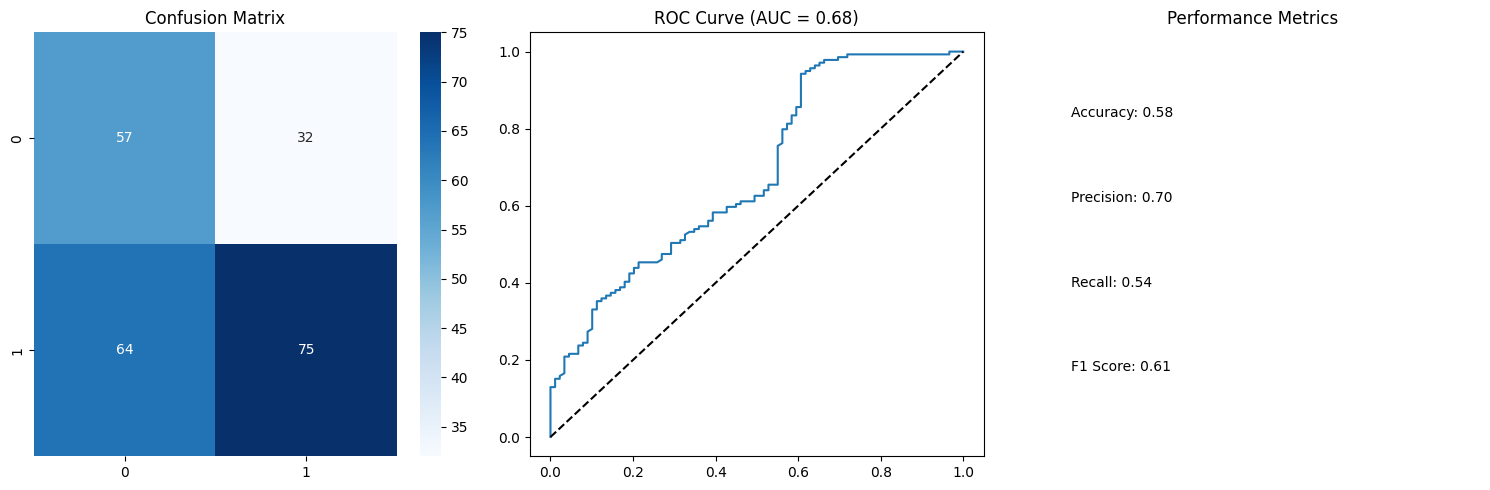


Validation Metrics:
accuracy: 0.5789
precision: 0.7009
recall: 0.5396
f1: 0.6098
roc_auc: 0.6835


In [61]:
# Example usage
if __name__ == "__main__":
    # 1. Load your data
    # df = pd.read_csv('your_data.csv')
    # features = ['Close', 'Volume', 'RSI', 'MACD']
    
    # 2. Prepare data
    train_loader, val_loader = prepare_financial_data(df, features)
    
    # 3. Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FinancialTransformer(feature_dim=len(features)).to(device)
    
    # 4. Train model (assuming you have a training function)
    model = train_model(model, train_loader, val_loader)
    
    # 5. Evaluate
    print("Evaluating on validation set...")
    val_metrics, val_probs, val_targets = evaluate_model(model, val_loader)
    plot_results(val_metrics, val_probs, val_targets)
    
    print("\nValidation Metrics:")
    for k, v in val_metrics.items():
        if k != 'confusion_matrix':
            print(f"{k}: {v:.4f}")

In [65]:
def predict_future_transformer(data_df, model, features, lookback=60, horizon=15):
    """
    Predict future market trend using transformer model
    
    Args:
        data_df: DataFrame with feature data
        model: Trained FinancialTransformer model
        features: List of feature names to use
        lookback: Number of days to look back (should match model's expected sequence length)
        horizon: Prediction horizon (15 days in our case)
        
    Returns:
        Boolean indicating uptrend (True) or downtrend (False)
        Dictionary containing full prediction details
    """
    device = next(model.parameters()).device
    
    # Get the last lookback days of data
    recent_data = data_df[features].tail(lookback).values
    
    # Normalize the data - applying the same normalization logic as in prepare_financial_data
    normalized_data = recent_data.copy()
    for i, feature in enumerate(features):
        if feature in data_df.columns:
            # Use the same normalization as prepare_financial_data
            train_size = int(len(data_df) * 0.8)  # Same 80% train split as prepare_financial_data
            train_data = data_df[feature].iloc[:train_size]
            
            if train_data.max() == train_data.min():
                normalized_data[:, i] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                normalized_data[:, i] = (recent_data[:, i] - min_val) / (max_val - min_val + 1e-8)
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.FloatTensor(normalized_data).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad(), autocast(device_type='cuda'):
        output = model(input_tensor)['15day']
        prob = torch.sigmoid(output).item()
    
    # Create prediction dictionary
    prediction = {
        'prediction': 'UP' if prob > 0.5 else 'DOWN',
        'probability': prob,
        'confidence': max(prob, 1 - prob)
    }
    
    print(f"Market trend prediction for {horizon} days ahead: {prediction['prediction']}")
    print(f"Probability: {prediction['probability']:.4f}")
    print(f"Confidence: {prediction['confidence']:.4f}")
    
    # Return both boolean and full prediction details
    return prediction['prediction'] == 'UP', prediction

# Example usage
if __name__ == "__main__":
    # Assuming you have:
    # data = your pandas DataFrame with market data
    # trained_model = your trained FinancialTransformer
    # features = list of feature names
    
    future_prediction, pred_details = predict_future_transformer(
        data_df=data,
        model=model,
        features=features,
        lookback=60,  # Should match what you used in prepare_financial_data
        horizon=15
    )
    
    print(f"Prediction for next {15} trading days: {'Uptrend' if future_prediction else 'Downtrend'}")
    print("Full prediction details:", pred_details)

Market trend prediction for 15 days ahead: DOWN
Probability: 0.0571
Confidence: 0.9429
Prediction for next 15 trading days: Downtrend
Full prediction details: {'prediction': 'DOWN', 'probability': 0.05706787109375, 'confidence': 0.94293212890625}
